<a href="https://colab.research.google.com/github/PattarapornH/Crab-Molting-Detection/blob/master/Molting_crab_tracker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
path_dir = 'gdrive/My Drive/Year4/Project/top_view/Case10_2018_09_29_Coor(5_2)/'
# /content/gdrive/My Drive/Year4/Project/top_view/Case1_2018_12_29_Camera1_Coor(1_1)
path = []

for p in os.listdir(path_dir):
  # print(p)
  path.append(p)

path.sort()
path[0:10]

['21-20-05.png',
 '21-20-15.png',
 '21-20-25.png',
 '21-20-35.png',
 '21-20-45.png',
 '21-20-55.png',
 '21-21-05.png',
 '21-21-15.png',
 '21-21-25.png',
 '21-21-35.png']

In [0]:
from google.colab.patches import cv2_imshow

def plot_img(image):
  # shape = image.shape
  # img_resize = cv.resize(image,(int(shape[1]/2),int(shape[0]/2)))
  cv2_imshow(image)

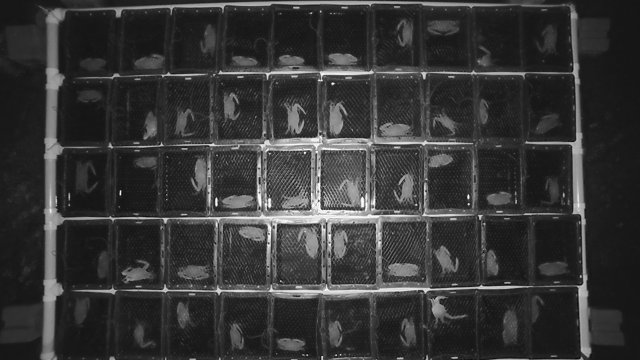

In [5]:
import cv2 as cv

data = []

for p in path:
  img = cv.imread(path_dir+'/'+p)
  shape = img.shape
  img_resize = cv.resize(img,(int(shape[1]/2),int(shape[0]/2)))
  data.append(img_resize)

plot_img(data[0])
# data[0].shape

In [6]:
data[0].shape

(360, 640, 3)

# Equalize Histogram

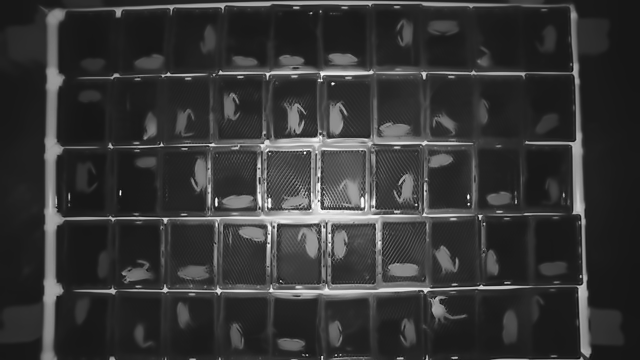

In [7]:
img = cv.fastNlMeansDenoisingColored(data[0],None,10,10,7,21)
gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
plot_img(gray)

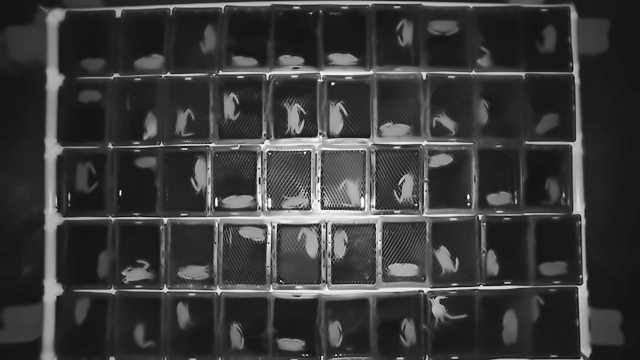

In [8]:
clahe = cv.createCLAHE(clipLimit=1.0, tileGridSize=(9,9))
cl1 = clahe.apply(gray)
plot_img(cl1)

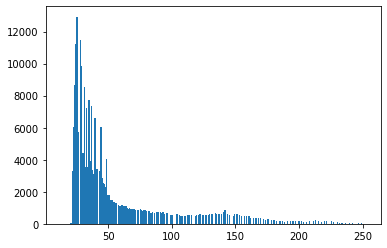

In [9]:
_ = plt.hist(gray.flatten(),bins = 255)

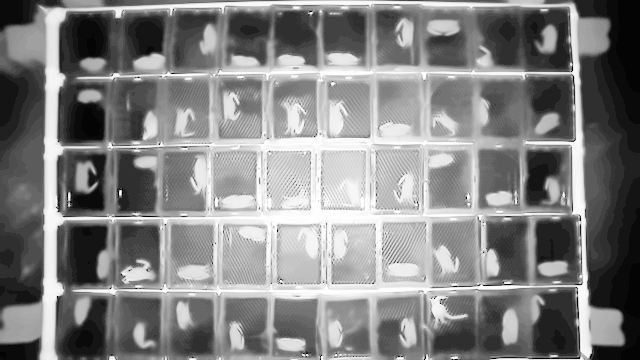

In [10]:
eq = cv.equalizeHist(gray)
plot_img(eq)

In [11]:
eq.shape

(360, 640)

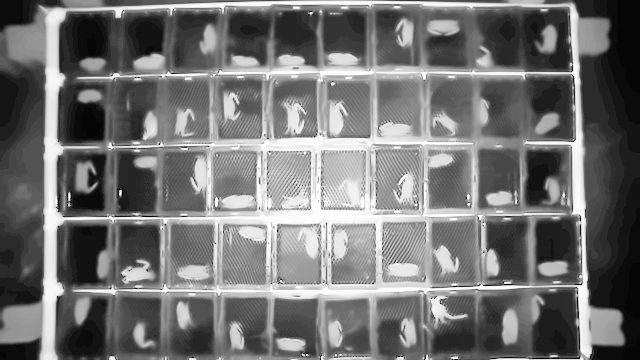

In [12]:
clahe = cv.createCLAHE(clipLimit=1.0, tileGridSize=(5,5))
cl1 = clahe.apply(eq)
plot_img(cl1)

.............................................................
complete


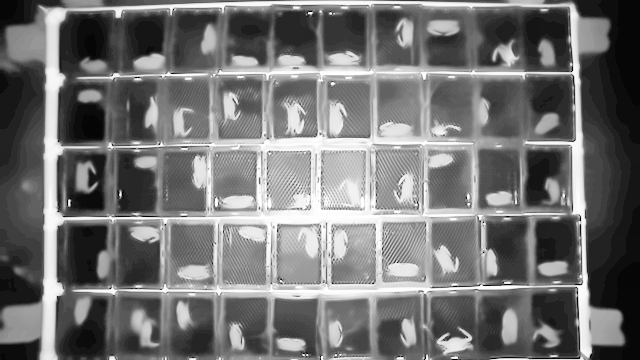

In [13]:
clean_data = []

for i in range(len(data)):
  print('.',end='')
  img = cv.fastNlMeansDenoisingColored(data[i],None,10,10,7,21)
  gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
  eq = cv.equalizeHist(gray)
  clahe = cv.createCLAHE(clipLimit=1.0, tileGridSize=(5,5))
  cl1 = clahe.apply(eq)
  clean_data.append(cl1)

print('\ncomplete')
plot_img(clean_data[60])

.............................................................

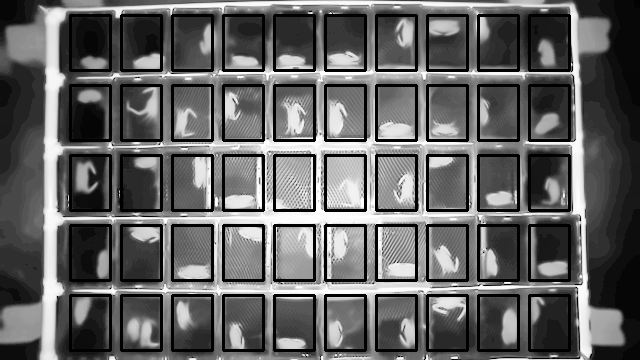

In [14]:
rect = []
series = dict()

START_X = 70
START_Y = 15
WIDTH = 40
HEIGHT = 55
DELTA_X = 51
DELTA_Y = 70
pos = ['A','B','C','D','E']

def draw_rect(img,time_series):
  for i in range(10):
    for j in range(5):
      x = START_X+(DELTA_X*i)
      y = START_Y+(DELTA_Y*j)
      cv.rectangle(img,(x,y),(x+WIDTH,y+HEIGHT),(0,255,0),2)
      if(pos[j]+str(i+1) not in time_series):
        time_series[pos[j]+str(i+1)] = [(img[y:y+HEIGHT,x:x+WIDTH],)]
      else:
        time_series[pos[j]+str(i+1)].append((img[y:y+HEIGHT,x:x+WIDTH],))

for i in range(len(clean_data)):
  print('.',end='')
  tmp = np.array(clean_data[i])
  draw_rect(tmp,series)
  rect.append(tmp)
plot_img(rect[47])

In [0]:
# key = 'D10'
# series contain key(position) : [tuple(crop_img,theshold,mean),...,...]
for key in series:
  for i in range(len(series[key])):
    tmp = np.array(series[key][i][0])
    if(np.mean(tmp) > 35):
      tmp = cv.convertScaleAbs(tmp, alpha=1, beta=-(np.mean(tmp)-35))
    bll = cv.medianBlur(tmp,5)
    _, th1 = cv.threshold(bll, 100, 255,cv.THRESH_BINARY)
    series[key][i]  = series[key][i] + (th1,np.mean(th1))
  # print('key: {0}, mean: {1} {3}, index: {2}'.format(key,series[key][i][2],i,np.mean(th1)))
  # plot_img(series[key][i][0])
  # plot_img(bll)
  # plot_img(th1)

In [18]:
# print(series['A1'][0][2])
# print(series['A1'][-1][2])
for key in series.keys():
  if(series[key][-1][2] - series[key][0][2] > 20):
    print(key)

E2


In [0]:
time_series = dict()

for key in series:
  for i in range(len(series[key])-1):
    diff = np.count_nonzero(series[key][i+1][1] - series[key][i][1])
    if(key not in time_series):
      time_series[key] = [diff]
    else:
      time_series[key].append(diff)

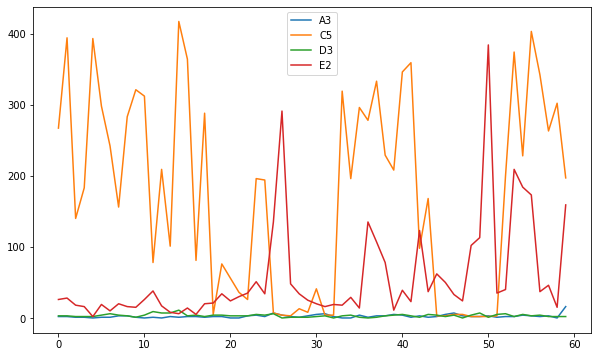

In [20]:
plt.figure(figsize=(10,6))
# for key in time_series:
#   plt.plot(time_series[key],label=key)
plt.plot(time_series['A3'],label='A3')
plt.plot(time_series['C5'],label='C5')
plt.plot(time_series['D3'],label='D3')
plt.plot(time_series['E2'],label='E2')
plt.legend()


In [0]:
X = []
y = []
for key in time_series.keys():
  X.append(time_series[key])
  if(key == 'E2'):
    y.append(1)
  else:
    y.append(0)
X = np.array(X)
y = np.array(y)
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
# X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [22]:
from keras.utils import np_utils
y = np_utils.to_categorical(y)
y[0]

Using TensorFlow backend.


array([1., 0.], dtype=float32)

In [23]:
print(X.shape,y.shape)

(50, 1, 60) (50, 2)


In [0]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [25]:
print(X_train.shape,y_train.shape)

(40, 1, 60) (40, 2)


In [26]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

model = Sequential()
model.add(LSTM(128, input_shape=X_train.shape[1:], activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 128)            96768     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_

In [27]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'],)
train_model = model.fit(X_train,y_train,epochs=50, validation_split=0.1)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 36 samples, validate on 4 samples
Epoch 1/50





36/36 [==============================] - 2s 61ms/step - loss: 0.6930 - acc: 0.7222 - val_loss: 1.2633 - val_acc: 0.7500
Epoch 2/50
36/36 [==============================] - 0s 1ms/step - loss: 0.4042 - acc: 0.9722 - val_loss: 0.4686 - val_acc: 0.7500
Epoch 3/50
36/36 [==============================] - 0s 922us/step - loss: 0.5047 - acc: 0.9722 - val_loss: 0.1418 - val_acc: 1.0000
Epoch 4/50
36/36 [==============================] - 0s 909us/step - loss: 0.2951 - acc: 0.9722 - val_loss: 0.0820 - val_acc: 1.0000
Epoch 5/50
36/36 [==============================] - 0s 1ms/step - loss: 0.1743 - acc: 0.9722 - val_loss: 0.0508 - val_acc: 1.0000
Epoch 6/50
36/36 [==============================] - 0s 936us/step - loss: 0.4943 - acc: 0.9722 - val_loss: 0.0285 - val_acc: 1.0000
Epoch 7/50
36/36 [==============================] - 0s 990us/step 

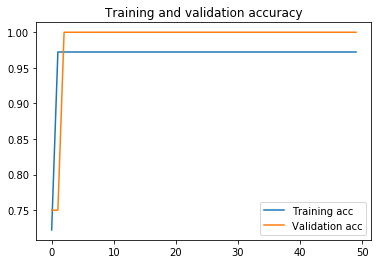

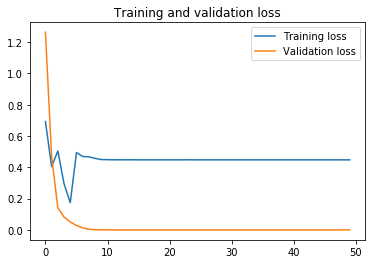

In [28]:
acc = train_model.history['acc']
val_acc = train_model.history['val_acc']
loss = train_model.history['loss']
val_loss = train_model.history['val_loss']


plt.plot(acc, label='Training acc')
plt.plot(val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()